<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"></ul></div>

# AutoEncoders <a class="tocSkip">

In [1]:
import os

import numpy as np
np.random.seed(123)
print("NumPy:{}".format(np.__version__))

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=15,10
print("Matplotlib:{}".format(mpl.__version__))

import tensorflow as tf
tf.set_random_seed(123)
print("TensorFlow:{}".format(tf.__version__))

import keras
print("Keras:{}".format(keras.__version__))

NumPy:1.13.1
Matplotlib:2.1.0
TensorFlow:1.4.1


Using TensorFlow backend.


Keras:2.0.9


In [2]:
DATASETSLIB_HOME = '../datasetslib'
import sys
if not DATASETSLIB_HOME in sys.path:
    sys.path.append(DATASETSLIB_HOME)
%reload_ext autoreload
%autoreload 2
import datasetslib

datasetslib.datasets_root = os.path.join(os.path.expanduser('~'),'datasets')

# Get the MNIST data

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
dataset_home = os.path.join(datasetslib.datasets_root,'mnist') 
mnist = input_data.read_data_sets(dataset_home,one_hot=False)

X_train = mnist.train.images
X_test = mnist.test.images
Y_train = mnist.train.labels
Y_test = mnist.test.labels

pixel_size = 28 

Extracting /home/armando/datasets/mnist/train-images-idx3-ubyte.gz
Extracting /home/armando/datasets/mnist/train-labels-idx1-ubyte.gz
Extracting /home/armando/datasets/mnist/t10k-images-idx3-ubyte.gz
Extracting /home/armando/datasets/mnist/t10k-labels-idx1-ubyte.gz


In [4]:
# Get four distinct images and labels from train and test data
while True:
    train_images,train_labels = mnist.train.next_batch(4)
    if len(set(train_labels))==4:
        break
while True:
    test_images,test_labels = mnist.test.next_batch(4)
    if len(set(test_labels))==4:
        break

In [5]:
import random

# Function to display the images and labels
# images should be in NHW or NHWC format
def display_images(images, labels, count=0, one_hot=False):
    # if number of images to display is not provided, then display all the images
    if (count==0):
        count = images.shape[0]
        
    idx_list = random.sample(range(len(labels)),count)
    for i in range(count):
        plt.subplot(4, 4, i+1)
        plt.title(labels[i])
        plt.imshow(images[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Simple AutoEncoder in TensorFlow

In [6]:
# hyperparameters
learning_rate = 0.001
n_epochs = 20
batch_size = 100
n_batches = int(mnist.train.num_examples/batch_size)

# number of pixels in the MNIST image as number of inputs
n_inputs = 784
n_outputs = n_inputs

# input images
x = tf.placeholder(dtype=tf.float32, name="x", shape=[None, n_inputs]) 
# output images
y = tf.placeholder(dtype=tf.float32, name="y", shape=[None, n_outputs]) 

# number of hidden layers
n_layers = 2
# neurons in each hidden layer
n_neurons = [512,256]
# add decoder layers:
n_neurons.extend(list(reversed(n_neurons)))
n_layers = n_layers * 2

# definew and b parameters
w=[]
b=[]

for i in range(n_layers):
    w.append(tf.Variable(tf.random_normal([n_inputs if i==0 else n_neurons[i-1],
                                           n_neurons[i]]),
                         name="w_{0:04d}".format(i) 
                        )
            ) 
    b.append(tf.Variable(tf.zeros([n_neurons[i]]),
                         name="b_{0:04d}".format(i) 
                        )
            )                   
w.append(tf.Variable(tf.random_normal([n_neurons[n_layers-1] if n_layers > 0 else n_inputs,
                                       n_outputs]),
                     name="w_out"
                    )
        )
b.append(tf.Variable(tf.zeros([n_outputs]),name="b_out"))

# x is input layer
layer = x

# add hidden layers
for i in range(n_layers):
    layer = tf.nn.sigmoid(tf.matmul(layer, w[i]) + b[i]) 

# add output layer
layer = tf.nn.sigmoid(tf.matmul(layer, w[n_layers]) + b[n_layers])
    
model = layer

mse = tf.losses.mean_squared_error
loss = mse(predictions=model, labels=y)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
optimizer = optimizer.minimize(loss)

In [7]:
with tf.Session() as tfs:
    tf.global_variables_initializer().run()
    for epoch in range(n_epochs):
        epoch_loss = 0.0
        for batch in range(n_batches):
            X_batch, _ = mnist.train.next_batch(batch_size)
            feed_dict={x: X_batch,y: X_batch}
            _,batch_loss = tfs.run([optimizer,loss], feed_dict)
            epoch_loss += batch_loss 
        if (epoch%10==9) or (epoch==0):
            average_loss = epoch_loss / n_batches
            print('epoch: {0:04d}   loss = {1:0.6f}'
                  .format(epoch,
                          average_loss))

    # predict images using trained autoencoder model            
    Y_train_pred = tfs.run(model, feed_dict={x: train_images})
    Y_test_pred = tfs.run(model, feed_dict={x: test_images})

epoch: 0000   loss = 0.156697
epoch: 0009   loss = 0.091331
epoch: 0019   loss = 0.078746


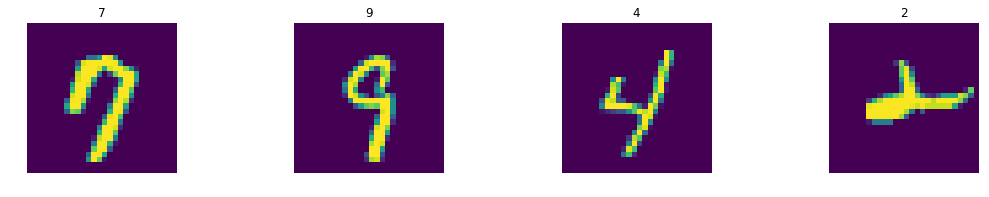

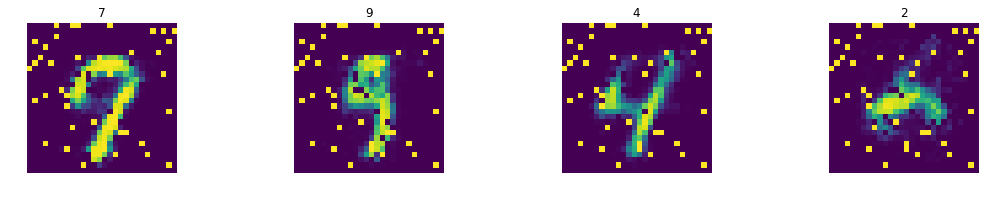

In [8]:
display_images(train_images.reshape(-1,pixel_size,pixel_size),train_labels)
display_images(Y_train_pred.reshape(-1,pixel_size,pixel_size),train_labels)

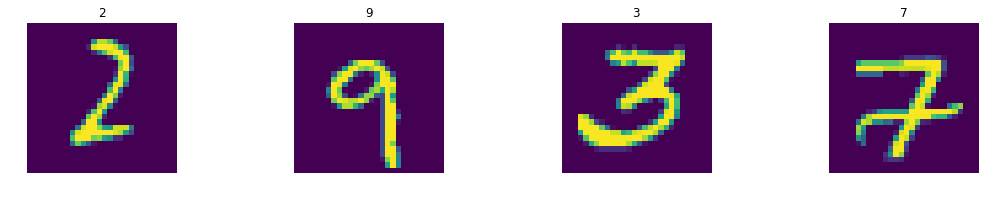

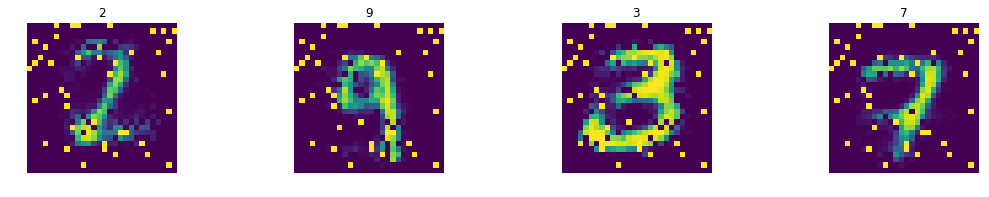

In [9]:
display_images(test_images.reshape(-1,pixel_size,pixel_size),test_labels)
display_images(Y_test_pred.reshape(-1,pixel_size,pixel_size),test_labels)

# Stacked AutoEncoder in Keras

In [10]:
tf.reset_default_graph()
keras.backend.clear_session()

In [11]:
import keras
from keras.layers import Dense
from keras.models import Sequential

# hyperparameters
learning_rate = 0.001
n_epochs = 20
batch_size = 100
n_batches = int(mnist.train.num_examples/batch_size)

# number of pixels in the MNIST image as number of inputs
n_inputs = 784
n_outputs = n_inputs

# number of hidden layers
n_layers = 2
# neurons in each hidden layer
n_neurons = [512,256]
# add decoder layers:
n_neurons.extend(list(reversed(n_neurons)))
n_layers = n_layers * 2

model = Sequential()

# add input to first layer
model.add(Dense(units=n_neurons[0], activation='relu', 
                input_shape=(n_inputs,)))

for i in range(1,n_layers):
    model.add(Dense(units=n_neurons[i], activation='relu'))
    
# add last layer as output layer
model.add(Dense(units=n_outputs, activation='linear'))
model.summary()

model.compile(loss='mse',
              optimizer=keras.optimizers.Adam(lr=learning_rate),
              metrics=['accuracy'])

model.fit(X_train, X_train,
                    batch_size=batch_size,
                    epochs=n_epochs)

Y_train_pred = model.predict(train_images)
Y_test_pred = model.predict(test_images)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_5 (Dense)              (None, 784)               402192    
Total params: 1,132,816
Trainable params: 1,132,816
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
55000/55000 [==============================] - 2s 37us/step - loss: 0.0194 - acc: 0.0121
Epoch 2/20
55000/55000 [========

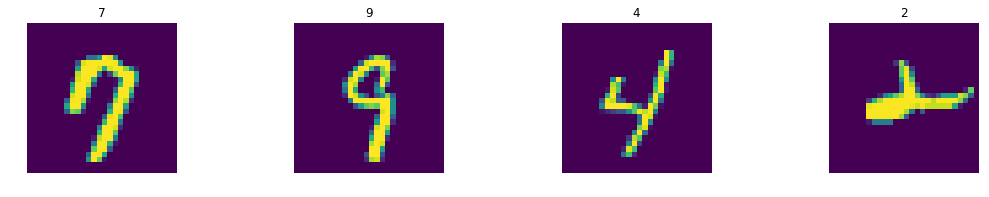

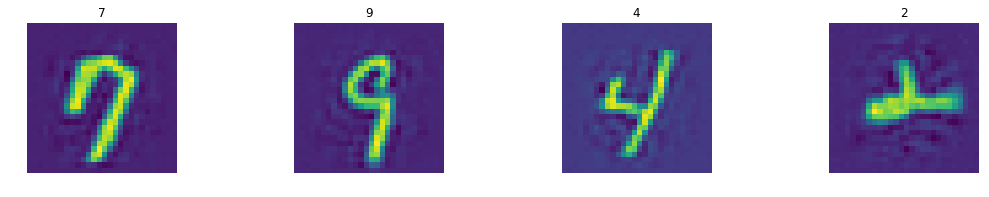

In [12]:
display_images(train_images.reshape(-1,pixel_size,pixel_size),train_labels)
display_images(Y_train_pred.reshape(-1,pixel_size,pixel_size),train_labels)

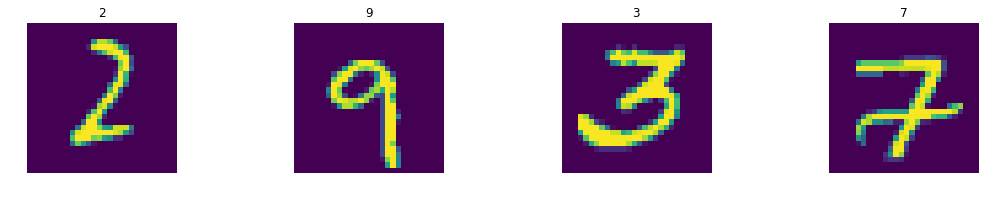

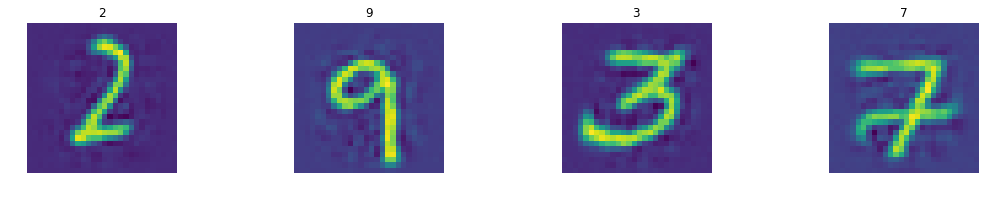

In [13]:
display_images(test_images.reshape(-1,pixel_size,pixel_size),test_labels)
display_images(Y_test_pred.reshape(-1,pixel_size,pixel_size),test_labels)

# Add noise to test images

In [14]:
def add_noise(X):
    return X + 0.5 * np.random.randn(X.shape[0],X.shape[1])

In [15]:
test_images_noisy = add_noise(test_images)

# Denoising AutoEncoder in TensorFlow

In [16]:
tf.reset_default_graph()
keras.backend.clear_session()

In [17]:
# hyperparameters
learning_rate = 0.001
n_epochs = 20
batch_size = 100
n_batches = int(mnist.train.num_examples/batch_size)

# number of pixels in the MNIST image as number of inputs
n_inputs = 784
n_outputs = n_inputs

# input images
x = tf.placeholder(dtype=tf.float32, name="x", shape=[None, n_inputs]) 

# output images
y = tf.placeholder(dtype=tf.float32, name="y", shape=[None, n_outputs]) 

# number of hidden layers
n_layers = 2
# neurons in each hidden layer
n_neurons = [512,256]

# add decoder layers:
n_neurons.extend(list(reversed(n_neurons)))
n_layers = n_layers * 2

w=[]
b=[]

for i in range(n_layers):
    # weights
    w.append(tf.Variable(tf.random_normal([n_inputs if i==0 else n_neurons[i-1],
                                           n_neurons[i]]),
                         name="w_{0:04d}".format(i) 
                        )
            ) 
    # biases
    b.append(tf.Variable(tf.zeros([n_neurons[i]]),
                         name="b_{0:04d}".format(i) 
                        )
            )                   
w.append(tf.Variable(tf.random_normal([n_neurons[n_layers-1] if n_layers > 0 else n_inputs,
                                       n_outputs]),
                     name="w_out"
                    )
        )
b.append(tf.Variable(tf.zeros([n_outputs]),name="b_out"))

# x is input layer
layer = x

# add hidden layers
for i in range(n_layers):
    layer = tf.nn.sigmoid(tf.matmul(layer, w[i]) + b[i]) 

# add output layer
layer = tf.nn.sigmoid(tf.matmul(layer, w[n_layers]) + b[n_layers])
    
model = layer

mse=tf.losses.mean_squared_error
loss = mse(predictions=model, labels=y)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
optimizer = optimizer.minimize(loss)

In [18]:
n_epochs = 100

with tf.Session() as tfs:
    tf.global_variables_initializer().run()
    for epoch in range(n_epochs):
        epoch_loss = 0.0
        for batch in range(n_batches):
            X_batch, _ = mnist.train.next_batch(batch_size)
            X_batch_noisy = add_noise(X_batch)
            feed_dict={x: X_batch_noisy, y: X_batch}
            _,batch_loss = tfs.run([optimizer,loss], feed_dict=feed_dict)
            epoch_loss += batch_loss 
        if (epoch%10==9) or (epoch==0):
            average_loss = epoch_loss / n_batches
            print('epoch: {0:04d}   loss = {1:0.6f}'
                  .format(epoch,average_loss))
            
    Y_test_pred1 = tfs.run(model, feed_dict={x: test_images})
    Y_test_pred2 = tfs.run(model, feed_dict={x: test_images_noisy})

epoch: 0000   loss = 0.147567
epoch: 0009   loss = 0.097514
epoch: 0019   loss = 0.087566
epoch: 0029   loss = 0.080724
epoch: 0039   loss = 0.077055
epoch: 0049   loss = 0.075069
epoch: 0059   loss = 0.073064
epoch: 0069   loss = 0.072101
epoch: 0079   loss = 0.071337
epoch: 0089   loss = 0.070251
epoch: 0099   loss = 0.069607


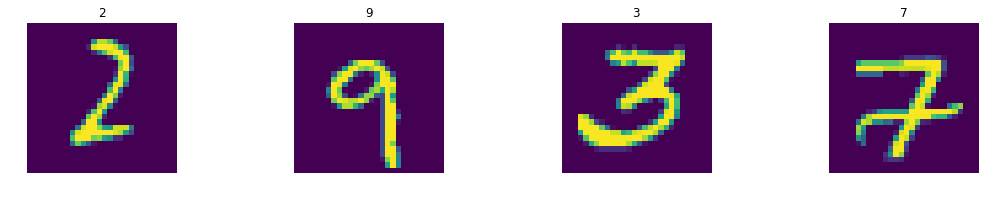

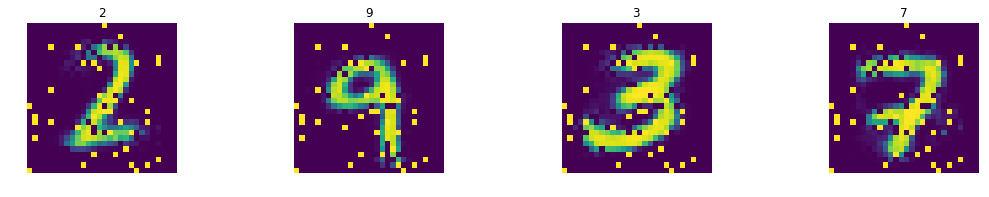

In [19]:
display_images(test_images.reshape(-1,pixel_size,pixel_size),test_labels)
display_images(Y_test_pred1.reshape(-1,pixel_size,pixel_size),test_labels)

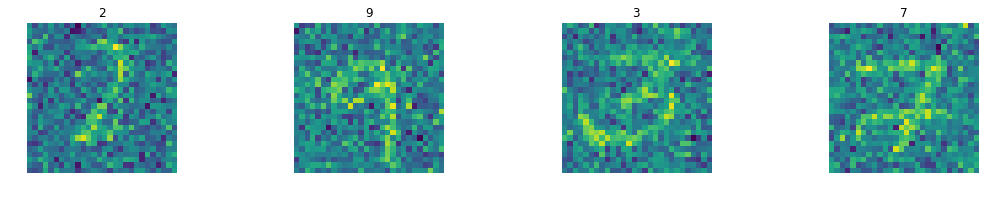

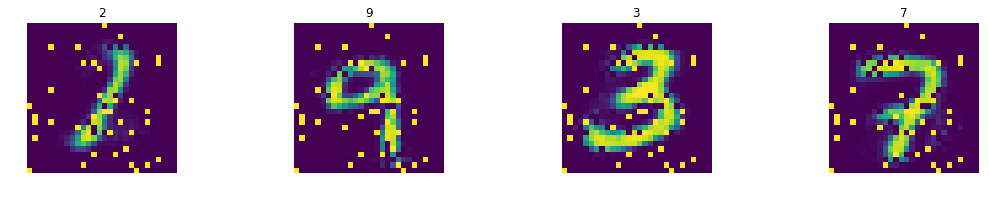

In [20]:
display_images(test_images_noisy.reshape(-1,pixel_size,pixel_size),test_labels)
display_images(Y_test_pred2.reshape(-1,pixel_size,pixel_size),test_labels)

# Denoising AutoEncoder in Keras

In [21]:
X_train_noisy = add_noise(X_train)

In [22]:
tf.reset_default_graph()
keras.backend.clear_session()

In [23]:
import keras
from keras.layers import Dense
from keras.models import Sequential

# hyperparameters
learning_rate = 0.001
batch_size = 100
n_batches = int(mnist.train.num_examples/batch_size)

# number of pixels in the MNIST image as number of inputs
n_inputs = 784
n_outputs = n_inputs

# number of hidden layers
n_layers = 2
# neurons in each hidden layer
n_neurons = [512,256]

# add decoder layers:
n_neurons.extend(list(reversed(n_neurons)))

n_layers = n_layers * 2

model = Sequential()

# add input to first layer
model.add(Dense(units=n_neurons[0], activation='relu', 
                input_shape=(n_inputs,)))

for i in range(1,n_layers):
    model.add(Dense(units=n_neurons[i], activation='relu'))
    
# add last layer to output layer
model.add(Dense(units=n_outputs, activation='linear'))
model.summary()

model.compile(loss='mse',
              optimizer=keras.optimizers.Adam(lr=learning_rate)
             )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_5 (Dense)              (None, 784)               402192    
Total params: 1,132,816
Trainable params: 1,132,816
Non-trainable params: 0
_________________________________________________________________


In [24]:
n_epochs=100

model.fit(x=X_train_noisy, y=X_train,
                batch_size=batch_size,
                epochs=n_epochs,
                verbose=0)

Y_test_pred1 = model.predict(test_images)
Y_test_pred2 = model.predict(test_images_noisy)

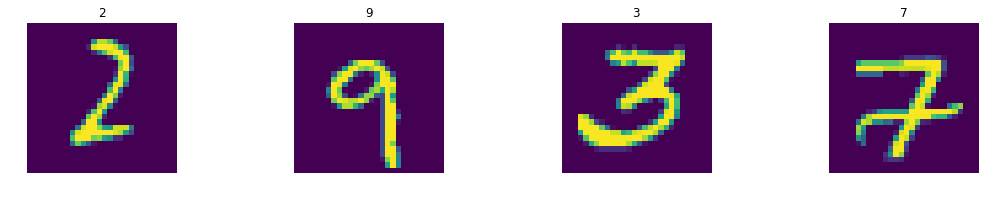

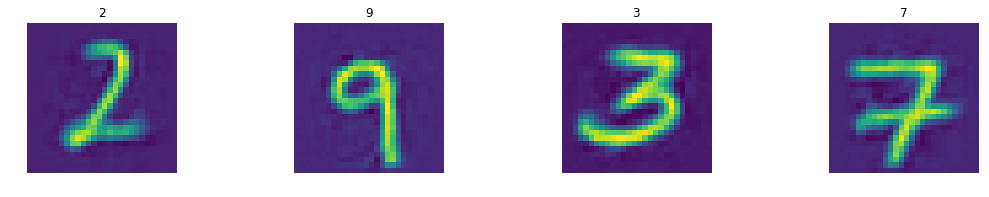

In [25]:
display_images(test_images.reshape(-1,pixel_size,pixel_size),test_labels)
display_images(Y_test_pred1.reshape(-1,pixel_size,pixel_size),test_labels)

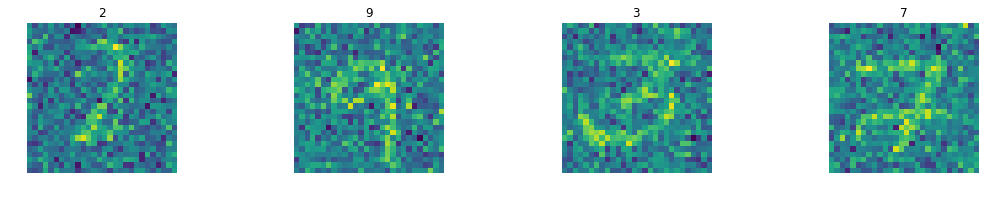

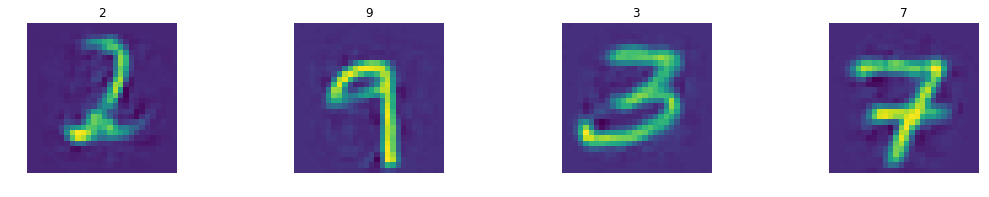

In [26]:
display_images(test_images_noisy.reshape(-1,pixel_size,pixel_size),test_labels)
display_images(Y_test_pred2.reshape(-1,pixel_size,pixel_size),test_labels)

# Variational Autoencoder in TensorFlow

In [27]:
tf.reset_default_graph()
keras.backend.clear_session()

In [28]:
# hyperparameters
learning_rate = 0.001
n_epochs = 20
batch_size = 100
n_batches = int(mnist.train.num_examples/batch_size)

# number of pixels in the MNIST image as number of inputs
n_inputs = 784
n_outputs = n_inputs


# define parameter ditionary
params={}

# number of hidden layers
n_layers = 2
# neurons in each hidden layer
n_neurons = [512,256]  

n_neurons_z = 128 # the dimensions of latent variables

activation = tf.nn.tanh

# input images
x = tf.placeholder(dtype=tf.float32, name='x', shape=[None, n_inputs]) 
# output images
y = tf.placeholder(dtype=tf.float32, name='y', shape=[None, n_outputs]) 

# x is input layer
layer = x

# add recognition / inference / probablistic encoder network weights, biases and layers

for i in range(0,n_layers):
    name='w_e_{0:04d}'.format(i)
    params[name] = tf.get_variable(name=name, 
                                   shape=[n_inputs if i==0 else n_neurons[i-1],
                                          n_neurons[i]], 
                                   initializer=tf.glorot_uniform_initializer()
                                  )
    name='b_e_{0:04d}'.format(i)
    params[name] = tf.Variable(tf.zeros([n_neurons[i]]),
                               name=name
                              )

    layer = activation(tf.matmul(layer,
                                 params['w_e_{0:04d}'.format(i)]
                                ) + params['b_e_{0:04d}'.format(i)]
                      )

name='w_e_z_mean'
params[name] = tf.get_variable(name=name,
                               shape=[n_neurons[n_layers-1], n_neurons_z],
                               initializer=tf.glorot_uniform_initializer()
                              )
name='b_e_z_mean'
params[name] = tf.Variable(tf.zeros([n_neurons_z]),
                           name=name
                          )
z_mean = tf.matmul(layer, params['w_e_z_mean']) + params['b_e_z_mean']

name='w_e_z_log_var'
params[name] = tf.get_variable(name=name,
                               shape=[n_neurons[n_layers-1], n_neurons_z],
                               initializer=tf.glorot_uniform_initializer()
                              )
name='b_e_z_log_var'
params[name] = tf.Variable(tf.zeros([n_neurons_z]),
                     name='b_e_z_log_var'
                    )

z_log_var = tf.matmul(layer, params['w_e_z_log_var']) + params['b_e_z_log_var']

# noise distribution
epsilon = tf.random_normal(tf.shape(z_log_var), 
                           mean=0, 
                           stddev=1.0,
                           dtype=tf.float32, 
                           name='epsilon'
                          )
# posterior distribution
z = z_mean + tf.exp(z_log_var * 0.5) * epsilon     


# add generator / probablistic decoder network weights, biases and layers
layer = z

for i in range(n_layers-1,-1,-1):
    name='w_d_{0:04d}'.format(i)
    params[name] = tf.get_variable(name=name, 
                                   shape=[n_neurons_z if i==n_layers-1 else n_neurons[i+1],
                                          n_neurons[i]], 
                                   initializer=tf.glorot_uniform_initializer()
                                  )
    name='b_d_{0:04d}'.format(i)
    params[name] = tf.Variable(tf.zeros([n_neurons[i]]),
                         name=name 
                        )
    layer = activation(tf.matmul(layer, params['w_d_{0:04d}'.format(i)]) + 
                          params['b_d_{0:04d}'.format(i)])    
    
    
name='w_d_z_mean'
params[name] = tf.get_variable(name=name,
                               shape=[n_neurons[0],n_outputs],
                               initializer=tf.glorot_uniform_initializer()
                              )
name='b_d_z_mean'
params[name] = tf.Variable(tf.zeros([n_outputs]),
                     name=name
                    )
name='w_d_z_log_var'    
params[name] = tf.Variable(tf.random_normal([n_neurons[0],
                                             n_outputs]),
                           name=name
                          )
name='b_d_z_log_var'
params[name] = tf.Variable(tf.zeros([n_outputs]),
                           name=name
                          )

layer = tf.nn.sigmoid(tf.matmul(layer, params['w_d_z_mean']) + 
                          params['b_d_z_mean'])
                        
model = layer

# loss function
rec_loss = -tf.reduce_sum(y 
                          * tf.log(1e-10 + model) 
                          + (1-y) 
                          * tf.log(1e-10 + 1 - model),
                          1
                         )
reg_loss = -0.5 * tf.reduce_sum(1 
                                + z_log_var 
                                - tf.square(z_mean) 
                                - tf.exp(z_log_var), 
                                1
                               )            
loss = tf.reduce_mean(rec_loss+reg_loss)
# optimizer function
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
optimizer = optimizer.minimize(loss)

In [29]:
with tf.Session() as tfs:
    tf.global_variables_initializer().run()
    for epoch in range(n_epochs):
        epoch_loss = 0.0
        for batch in range(n_batches):
            X_batch, _ = mnist.train.next_batch(batch_size)
            feed_dict={x: X_batch,y: X_batch}
            _,batch_loss = tfs.run([optimizer,loss], feed_dict=feed_dict)
            epoch_loss += batch_loss 
        if (epoch%10==9) or (epoch==0):
            average_loss = epoch_loss / n_batches
            print('epoch: {0:04d}   loss = {1:0.6f}'
                  .format(epoch,average_loss))

    # predict images using autoencoder model trained            
    Y_test_pred1 = tfs.run(model, feed_dict={x: test_images})
    Y_test_pred2 = tfs.run(model, feed_dict={x: test_images_noisy})

epoch: 0000   loss = 178.974197
epoch: 0009   loss = 106.536299
epoch: 0019   loss = 102.442220


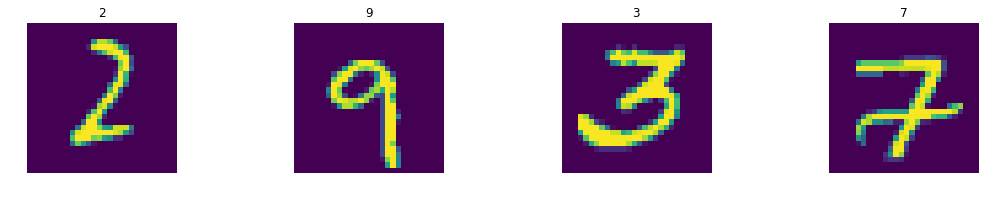

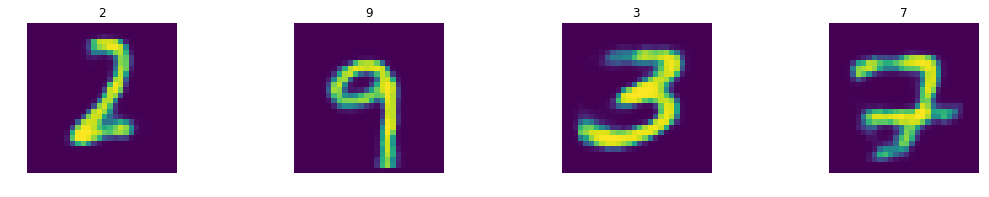

In [30]:
display_images(test_images.reshape(-1,pixel_size,pixel_size),test_labels)
display_images(Y_test_pred1.reshape(-1,pixel_size,pixel_size),test_labels)

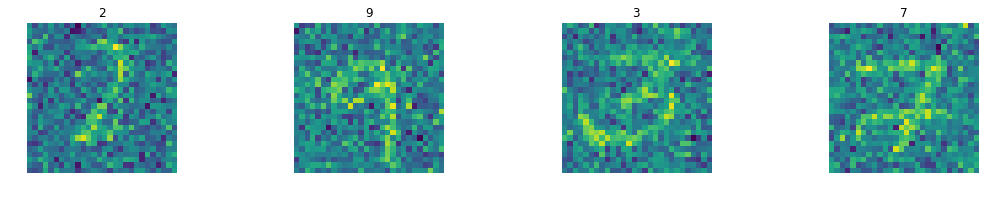

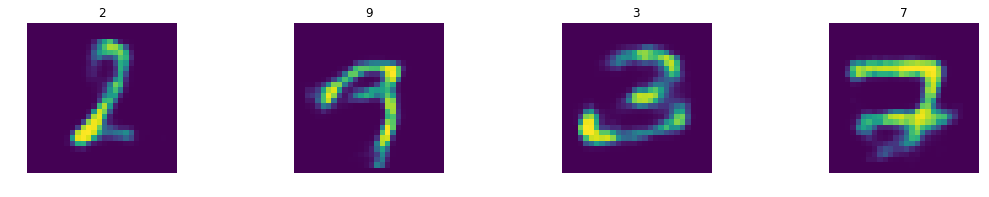

In [31]:
display_images(test_images_noisy.reshape(-1,pixel_size,pixel_size),test_labels)
display_images(Y_test_pred2.reshape(-1,pixel_size,pixel_size),test_labels)

# Variational Autoencoder in Keras

In [32]:
tf.reset_default_graph()
keras.backend.clear_session()

In [33]:
import keras
from keras.layers import Lambda, Dense, Input, Layer
from keras.models import Model
from keras import backend as K
    
# hyperparameters
learning_rate = 0.001
batch_size = 100
n_batches = int(mnist.train.num_examples/batch_size)

# number of pixels in the MNIST image as number of inputs
n_inputs = 784
n_outputs = n_inputs

# number of hidden layers
n_layers = 2
# neurons in each hidden layer
n_neurons = [512,256]
# the dimensions of latent variables
n_neurons_z = 128 

x = Input(shape=(n_inputs,), name='input')

layer = x

# build encoder
for i in range(n_layers):
    layer = Dense(units=n_neurons[i], activation='relu',name='enc_{0}'.format(i))(layer)

z_mean = Dense(units=n_neurons_z,name='z_mean')(layer)
z_log_var = Dense(units=n_neurons_z,name='z_log_v')(layer)


# noise distribution
epsilon = K.random_normal(shape=K.shape(z_log_var), 
                           mean=0, 
                           stddev=1.0
                         )

# posterior distribution
#z = Lambda(z_mean + K.exp(z_log_var * 0.5) * epsilon,
z = Lambda(lambda zargs: zargs[0] + K.exp(zargs[1] * 0.5) * epsilon,
           name='z'
          )([z_mean,z_log_var])

# add generator / probablistic decoder network layers
layer = z

for i in range(n_layers-1,-1,-1):
    layer = Dense(units=n_neurons[i], activation='relu',name='dec_{0}'.format(i))(layer)

y_hat = Dense(units=n_outputs, activation='sigmoid',name='output')(layer)

#y_hat = VAELossLayer()([x,layer])
                        
model = Model(x,y_hat)
model.summary()

def vae_loss(y, y_hat):
        rec_loss = -K.sum(y * K.log(1e-10 + y_hat) + (1-y) * K.log(1e-10 + 1 - y_hat), 
                          axis=-1)
        reg_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) 
         
        loss = K.mean(rec_loss+reg_loss)
        return loss

model.compile(loss=vae_loss,
              optimizer=keras.optimizers.Adam(lr=learning_rate)
             )

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 784)          0                                            
__________________________________________________________________________________________________
enc_0 (Dense)                   (None, 512)          401920      input[0][0]                      
__________________________________________________________________________________________________
enc_1 (Dense)                   (None, 256)          131328      enc_0[0][0]                      
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 128)          32896       enc_1[0][0]                      
__________________________________________________________________________________________________
z_log_v (D

In [34]:
n_epochs=50

model.fit(x=X_train_noisy, y=X_train,
                batch_size=batch_size,
                epochs=n_epochs,
                verbose=0)

Y_test_pred1 = model.predict(test_images)
Y_test_pred2 = model.predict(test_images_noisy)

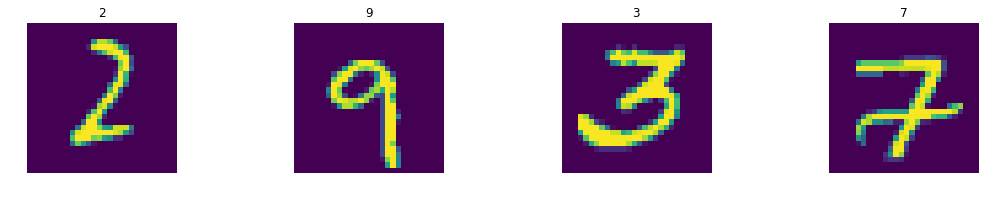

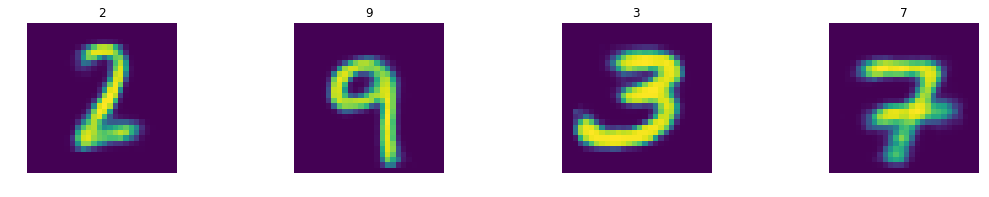

In [35]:
display_images(test_images.reshape(-1,pixel_size,pixel_size),test_labels)
display_images(Y_test_pred1.reshape(-1,pixel_size,pixel_size),test_labels)

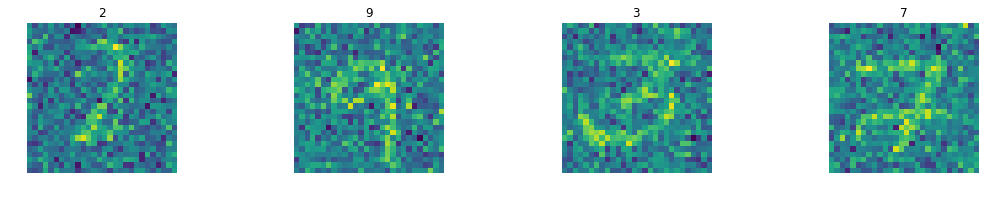

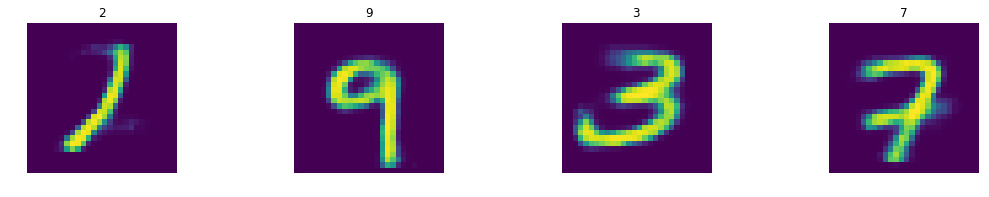

In [36]:
display_images(test_images_noisy.reshape(-1,pixel_size,pixel_size),test_labels)
display_images(Y_test_pred2.reshape(-1,pixel_size,pixel_size),test_labels)

In [37]:
encoder=Model(x,z_mean)
decoder_input = Input(shape=(n_neurons_z,))
decoder_layer = decoder_input
for i in range(n_layers-1,-1,-1):
    decoder_layer = model.get_layer('dec_{0}'.format(i))(decoder_layer)

y_decoded = model.get_layer('output')(decoder_layer)
generator = Model(decoder_input,y_decoded)